# Inspection Data

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 6g --executor-memory 6g
```

The general plan is to do some exploration and cleaning in jupyter notebooks, then run our actual models by submitting python scripts and letting the jobs run as we'd expect.

We'll clean the data and load them into cassandra tables to be used by the jobs.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [68]:
from pyspark.sql import Row
from pyspark.sql.types import *
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql.functions import lag, coalesce, rank, lit, when,col, udf, to_date, year, mean, month, date_format, array
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.ml.feature import StringIndexer
from datetime import datetime
from pyspark.sql.window import Window
import pyspark

## Exploration

Now, we can do some exploration of our data. Let's load in the inspection set from 2010 and onward.

We'll load the data file into DSEFS (DSE's Hadoop FS implementation). This should be reminiscent of the way Hadoop does things.

```bash
./dse fs
mkdir datadir
put /Users/angelo/chicago/data/Food_Inspections.csv datadir/Food_Inspections.csv

```

Now, we can start working with it... let's load it into the spark context

In [7]:
df2 = sqlContext.read.csv("dsefs:///datadir/Food_Inspections.csv", sep="|", header="True") \
    .cache()

In [8]:
df2.head(2)

[Row(Inspection ID=u'1970782', DBA Name=u"MARINO'S DISTRIBUTION , INC.", AKA Name=u"MARINO'S DISTRIBUTION", License #=u'2495906', Facility Type=u'Grocery Store', Risk=u'Risk 3 (Low)', Address=u'3939 S KEDZIE AVE ', City=u'CHICAGO', State=u'IL', Zip=u'60632', Inspection Date=u'11/3/16', Inspection Type=u'License', Results=u'Pass', Latitude=u'41.82145816', Longitude=u'-87.70435016', Location=u'(41.82145816352694, -87.70435016027005)'),
 Row(Inspection ID=u'1970772', DBA Name=u'STARBUCKS COFFEE #2827', AKA Name=u'STARBUCKS COFFEE #2827', License #=u'2093906', Facility Type=u'Restaurant', Risk=u'Risk 2 (Medium)', Address=u'1174 E 55TH ST ', City=u'CHICAGO', State=u'IL', Zip=u'60615', Inspection Date=u'11/3/16', Inspection Type=u'Canvass', Results=u'Pass', Latitude=u'41.79517545', Longitude=u'-87.59660148', Location=u'(41.79517545018063, -87.59660147733702)')]

In [9]:
rest = df2.filter(df2["Facility Type"] == "Restaurant").cache()
rest.count()

87952

Let's take a look at some of the data... what does Risk and Results look like?

In [10]:
rest.select("Risk").distinct().toPandas()

,Risk
0,None
1,Risk 1 (High)
2,All
3,Risk 2 (Medium)
4,Risk 3 (Low)


In [11]:
rest.select("Results").distinct().toPandas()

,Results
0,Not Ready
1,Fail
2,No Entry
3,Business Not Located
4,Pass w/ Conditions
5,Out of Business
6,Pass


Hopefully, we're only looking at chicago data. If so, city and state aren't terribly useful for us. Note the data collection errors...

In [12]:
rest.select("City").distinct().toPandas()

,City
0,chicago
1,CHICAGOI
2,None
3,Chicago
4,CHICAGO
5,CCHICAGO
6,CHICAGOCHICAGO


Inspection Type has data collection errors, too. That will be a problem for us. We'll need to clean them up.

In [13]:
rest.select("Inspection Type").distinct().toPandas()

,Inspection Type
0,Pre-License Consultation
1,fire complaint
2,SFP
3,CHANGED COURT DATE
4,KITCHEN CLOSED FOR RENOVATION
5,LIQUOR CATERING
6,TASK FORCE NOT READY
7,CANVASS
8,LICENSE/NOT READY
9,No entry


In [14]:
rest = rest.replace(
    ["TWO PEOPLE ATE AND GOT SICK.", "TASK FORCE LIQUOR (1481)", "Task Force Liquor 1475","Package Liquor 1474","1315 license reinspection","Out of Business","No entry","No Entry","LICENSE TASK FORCE / NOT -FOR-PROFIT CLU", "no entry","SFP/COMPLAINT", "SFP/Complaint","SFP","FIRE/COMPLAIN","fire complaint","CANVAS", "finish complaint inspection from 5-18-10","CANVASS FOR RIB FEST","CANVASS SPECIAL EVENTS","SFP RECENTLY INSPECTED","Short Form Fire-Complaint","NO ENTRY-SHORT COMPLAINT"],
    ["Suspected Food Poisoning", "Task Force Liquor","Task Force Liquor","Task Force Liquor","License Re-Inspection","OUT OF BUSINESS","NO ENTRY","NO ENTRY","LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB", "NO ENTRY","Suspected Food Poisoning","Suspected Food Poisoning","Suspected Food Poisoning","Complaint-Fire","Complaint-Fire", "Canvass", "Complaint","Special Events (Festivals)","Special Events (Festivals)","Recent Inspection","Complaint-Fire", "NO ENTRY"],
    "Inspection Type")

In [15]:
rest.select("Inspection Type").distinct().count()

47

In [16]:
rest = rest.filter((rest["Results"] == "Pass") | (rest["Results"] == "Pass w/ Conditions") | (rest["Results"] == "Fail"))

Let's drop some unnecessary columns. All of these are in Chicago, so let's lose City and State. Location is a string representing Logitude and Latitude, so that's duplicate data.

In [17]:
rest = rest.drop("City").drop("State").drop("Location")
rest.columns

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Results',
 'Latitude',
 'Longitude']

Now, let's recode the Pass/Fail as a binary value... 1 for fail and 0 for pass. We'll need that as our machine learning training label.

In [19]:
Y_col = when(col("Results") != "Fail", 0).otherwise(1)
rest2 = rest.withColumn("Y", Y_col)

In [20]:
#Get a simple list of inspection types
insp_types = rest.select("Inspection Type").distinct().toPandas()["Inspection Type"]

for i in insp_types:
    insp = rest.filter(rest["Inspection Type"] == i)
    total = float(insp.count())
    if(total != 0):
        print "P(Y=Fail|Inspection Type=%s) = %.4f" % (i, insp[insp["Results"] == 'Fail'].count()/total)
    else:
        print "P(Y=Fail|Inspection Type=%s) = %.4f" % (i, 0)

P(Y=Fail|Inspection Type=Pre-License Consultation) = 0.9000
P(Y=Fail|Inspection Type=CHANGED COURT DATE) = 0.0000
P(Y=Fail|Inspection Type=LIQUOR CATERING) = 1.0000
P(Y=Fail|Inspection Type=TASK FORCE NOT READY) = 1.0000
P(Y=Fail|Inspection Type=LICENSE/NOT READY) = 1.0000
P(Y=Fail|Inspection Type=Canvass) = 0.1982
P(Y=Fail|Inspection Type=Canvass Re-Inspection) = 0.0463
P(Y=Fail|Inspection Type=Special Events (Festivals)) = 0.1304
P(Y=Fail|Inspection Type=Consultation) = 0.1448
P(Y=Fail|Inspection Type=citation re-issued) = 0.0000
P(Y=Fail|Inspection Type=LICENSE REQUEST) = 1.0000
P(Y=Fail|Inspection Type=None) = 0.0000
P(Y=Fail|Inspection Type=Short Form Complaint) = 0.1273
P(Y=Fail|Inspection Type=OUT OF BUSINESS) = 0.4909
P(Y=Fail|Inspection Type=Complaint-Fire) = 0.3445
P(Y=Fail|Inspection Type=License Re-Inspection) = 0.1080
P(Y=Fail|Inspection Type=Recent Inspection) = 0.0684
P(Y=Fail|Inspection Type=Not Ready) = 1.0000
P(Y=Fail|Inspection Type=NO ENTRY) = 0.4821
P(Y=Fail|Inspec

We can remove some of these... for example, "Changed Court Date" and "error save" are housekeeping records more than an actual inspections.

In [21]:
rest2 = rest2.filter((rest2["Inspection Type"] != "error save") & (rest2["Inspection Type"] != "Changed Court Date"))

In [22]:
#What's the proportion of business that fail a license request?
lic = rest2[rest2["Inspection Type"] == 'LICENSE REQUEST']
lic[lic["Results"] == 'Fail'].count()/float(lic.count())

1.0

In [23]:
#what about a license reinspection?
lic = rest[rest["Inspection Type"] == 'License Re-Inspection']
lic[lic["Results"] == 'Fail'].count()/float(lic.count())

0.10801493823613904

Interesting... everyone fails when they first apply (makes sense, they've never done one) and then almost everyone passes on the reinspection. That's a reasonable expectation.

### Number of Inspections

In [24]:
df_inspection_stats = rest2[["Results", "License #"]] \
    .groupby("License #") \
    .count() \
    .select("License #", col("count").alias("total_inspections"))

failures = rest2[rest2["Results"] == "Fail"] \
    .groupby("License #") \
    .count() \
    .select("License #", col("count").alias("failed_inspections"))

df_inspection_stats = df_inspection_stats.join(failures, "License #")

df_inspection_stats = df_inspection_stats.withColumn("prop", df_inspection_stats["failed_inspections"]/df_inspection_stats["total_inspections"])

stat = df_inspection_stats.toPandas()
stat.head(5)

,License #,total_inspections,failed_inspections,prop
0,2397985,2,1,0.500000
1,2397851,3,1,0.333333
2,691,12,4,0.333333
3,64038,10,1,0.100000
4,2103019,8,1,0.125000


In [31]:
stat["total_inspections"].mean()

6.766249859186662

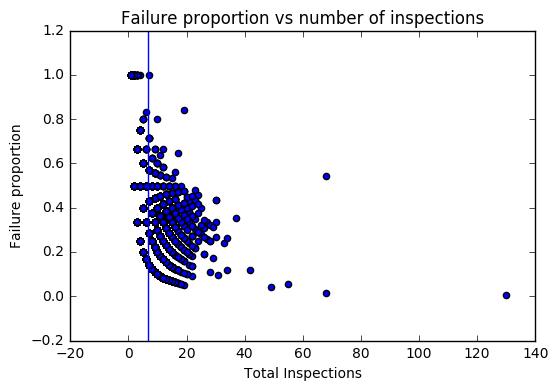

In [32]:
plt.scatter(stat["total_inspections"], stat["prop"] )
plt.axvline(stat["total_inspections"].mean(), label="Mean")
plt.xlabel("Total Inspections")
plt.ylabel("Failure proportion")
plt.title("Failure proportion vs number of inspections")


This is interesting... The more times an establishment is inspected, the smaller the failure proportion. That could mean a lot of things... does it mean they get better over time? You'd think that the more complaints, the more inspections, and the more failures...

### Inspection Frequency

In [50]:
#avg # inspections per year
string2Date = udf (lambda s: datetime.strptime(s, '%m/%d/%y'), DateType())
rest2 = rest2.withColumn("inspection_dt", string2Date(rest2["Inspection Date"]))
rest2.head()

Row(Inspection ID=u'1970772', DBA Name=u'STARBUCKS COFFEE #2827', AKA Name=u'STARBUCKS COFFEE #2827', License #=u'2093906', Facility Type=u'Restaurant', Risk=u'Risk 2 (Medium)', Address=u'1174 E 55TH ST ', Zip=u'60615', Inspection Date=u'11/3/16', Inspection Type=u'Canvass', Results=u'Pass', Latitude=u'41.79517545', Longitude=u'-87.59660148', Y=0, inspection_dt=datetime.date(2016, 11, 3))

In [60]:
dt_grp = rest2[["Results", "License #","inspection_dt"]] \
    .groupby(["License #", year(rest2["inspection_dt"]) \
    .alias("inspection_year")]) \
    .count() \
    .select("License #", col("count").alias("num_inspections"), "inspection_year")
    
dt_grp.head(5)

[Row(License #=u'50042', num_inspections=3, inspection_year=2016),
 Row(License #=u'2037878', num_inspections=1, inspection_year=2016),
 Row(License #=u'2027638', num_inspections=1, inspection_year=2016),
 Row(License #=u'1916161', num_inspections=2, inspection_year=2016),
 Row(License #=u'1927556', num_inspections=1, inspection_year=2016)]

In [81]:
dt_grp.filter(dt_grp.inspection_year == 2016).select("num_inspections").toPandas().mean()

num_inspections    1.496579
dtype: float64

### Repeat Offenders

The average number inspections per license. This might be interesting to consider how a particular establishment compares to the mean, and their failure rate.

In [94]:
#this_year = rest2[year(rest2["inspection_dt"]) == 2016]
#previous_years = rest2[year(rest2["inspection_dt"]) < 2016]

this_year = rest2[year(rest2["inspection_dt"]) == 2016][["License #", "Y"]] \
    .groupby("License #") \
    .max() \
    .select("License #", col("max(Y)").alias("this_Y"))



previous_years = rest2[year(rest2["inspection_dt"]) < 2016] \
    .groupby("License #") \
    .max() \
    .select("License #", col("max(Y)").alias("prev_Y"))

previous_fails = this_year.join(previous_years, "License #")

repeat_fail = previous_fails[(previous_fails["this_Y"] == 1) & (previous_fails["prev_Y"] == 1)].count()

new_fail = previous_fails[(previous_fails["this_Y"] == 1) & (previous_fails["prev_Y"] == 0)].count()

repeat_pass = previous_fails[(previous_fails["this_Y"] == 0) & (previous_fails["prev_Y"] == 0)].count()
new_pass = previous_fails[(previous_fails["this_Y"] == 0) & (previous_fails["prev_Y"] == 1)].count()
repeats = [repeat_fail, repeat_pass]

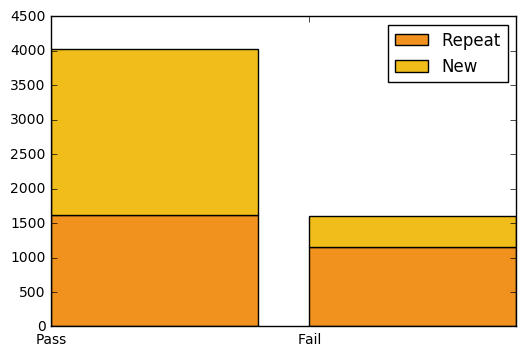

In [95]:
plt.bar([1,0],[repeat_fail, repeat_pass], label="Repeat", color='#F1911E')
plt.bar([1,0], [new_fail, new_pass], bottom=[repeat_fail, repeat_pass], label="New", color='#F1BD1A')
plt.xticks([1,0], ("Fail", "Pass"))

plt.legend(loc="best")

In [104]:
#risk?
print rest2[["Results", "Risk"]].groupby("Risk").count().head(10)

#overall probability of failing:
rest2[rest2["Y"] == 1].count()/float(rest.count())

[Row(Risk=None, count=3), Row(Risk=u'Risk 1 (High)', count=62506), Row(Risk=u'All', count=1), Row(Risk=u'Risk 2 (Medium)', count=15577), Row(Risk=u'Risk 3 (Low)', count=808)]


0.20896865533543735

### Risk Score

In [108]:
#how do the risk categories compare?
failures = rest2[rest2["Y"] == 1]

print "P(Risk=1|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 1 (High)"].count()/float(failures.count()))
print "P(Risk=1) = %4f" % (rest2[rest2["Risk"] == "Risk 1 (High)"].count()/float(rest2.count()))
print "# of Risk 1 passing = %4f" % (rest2[(rest2["Risk"] == "Risk 1 (High)") & (rest2["Y"] == 0)].count())

print "P(Risk=2|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 2 (Medium)"].count()/float(failures.count()))
print "P(Risk=2) = %4f" % (rest2[rest2["Risk"] == "Risk 2 (Medium)"].count()/float(rest2.count()))
print "# of Risk 2 passing = %4f" % (rest2[(rest2["Risk"] == "Risk 2 (Medium)") & (rest2["Y"] == 0)].count())

print "P(Risk=3|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 3 (Low)"].count()/float(failures.count()))
print "P(Risk=3) = %4f" % (rest2[rest2["Risk"] == "Risk 3 (Low)"].count()/float(rest2.count()))
print "# of Risk 4 passing = %4f" % (rest2[(rest2["Risk"] == "Risk 3 (Low)") & (rest2["Y"] == 0)].count())

P(Risk=1|Y=1) = 0.799418
P(Risk=1) = 0.792268
# of Risk 1 passing = 49326.000000
P(Risk=2|Y=1) = 0.187117
P(Risk=2) = 0.197440
# of Risk 2 passing = 12492.000000
P(Risk=3|Y=1) = 0.013223
P(Risk=3) = 0.010241
# of Risk 4 passing = 590.000000


Risk is interesting. Are they assessed this after inspection, or by the license type before hand? In any case, Failure seems to strongly follow risk for whatever reason.

### Failures Over Time

In [129]:
failures = rest2[rest2["Y"] == 1]

month_fail_grp = failures[["Results", "inspection_dt"]] \
    .groupby(month(failures["inspection_dt"])) \
    .count() \
    .select(col("month(inspection_dt)").alias("month"), col("count").alias("failures"))

month_all_grp = rest2[["Results", "inspection_dt"]] \
    .groupby(month(rest2["inspection_dt"])) \
    .count() \
    .select(col("month(inspection_dt)").alias("month"), col("count").alias("total"))
    
df_by_month = month_all_grp.join(month_fail_grp, "month")
df_by_month = df_by_month.withColumn("fail_prop", df_by_month["failures"]/df_by_month["total"])

df_by_month = df_by_month.toPandas()
df_by_month.head(20)

,month,total,failures,fail_prop
0,12,4527,849,0.187541
1,1,6288,1233,0.196088
2,6,7432,1594,0.214478
3,3,7201,1397,0.194001
4,5,7216,1496,0.207317
5,9,7132,1651,0.231492
6,4,6903,1417,0.205273
7,8,7487,1669,0.222920
8,7,6492,1449,0.223198
9,10,6806,1417,0.208199


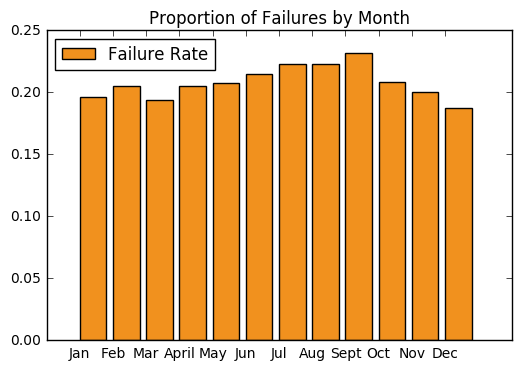

In [132]:
plt.bar(df_by_month["month"],df_by_month["fail_prop"], label="Failure Rate", color='#F1911E')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ("Jan", "Feb", "Mar", "April", "May", "Jun", "Jul", "Aug", "Sept", "Oct","Nov", "Dec"))
plt.legend(loc="best")
plt.title("Proportion of Failures by Month")

The failures seem to be highest in the hotter months.. July, August, September. Weather data may be helpful there. Of course, we're just guessing that it's because of temperature at this point.

In [153]:
day_fail_grp = failures[["Results", "inspection_dt"]] \
    .groupby(date_format(failures["inspection_dt"], 'E')) \
    .count() \
    .select(col("date_format(inspection_dt, E)").alias("weekday"), col("count").alias("failures"))

day_all_grp = rest2[["Results", "inspection_dt"]] \
    .groupby(date_format(rest2["inspection_dt"], 'E')) \
    .count() \
    .select(col("date_format(inspection_dt, E)").alias("weekday"), col("count").alias("total"))

df_by_day = day_all_grp.join(day_fail_grp, "weekday")
df_by_day = df_by_day.withColumn("fail_prop", df_by_day["failures"]/df_by_day["total"])

df_by_day = df_by_day.toPandas()
df_by_day.head()

,weekday,total,failures,fail_prop
0,Mon,13243,2872,0.216869
1,Thu,18204,3849,0.211437
2,Sat,26,8,0.307692
3,Wed,14332,2832,0.197600
4,Tue,17821,3907,0.219236


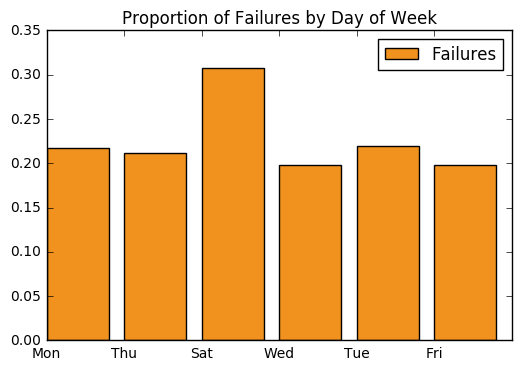

In [155]:
plt.bar(range(1,7),df_by_day["fail_prop"], label="Failures", color='#F1911E')
plt.xticks(range(1,7), df_by_day["weekday"])
plt.legend(loc="best")
plt.title("Proportion of Failures by Day of Week")

Failures are highest on Saturday and lowest on Wednesday. That's interesting. We didn't include this in the model, but it might be interesting to add a feature for it in the future.